# <span style="color:#336699">Plausability study of swissEO VHI values</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/stac-image-processing.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
<br>
<b>Abstract.</b> This Jupyter Notebook leads through the plausability study of the swissEO VHI product from data.geo.admin.ch and compares it with various data sources:

  - Combined drought index (CDI)
  - Treenet
  - Sanasilva
</div>

<hr style="border:1px solid #0077b9;">

### Set up connection to the STAC
<div>

Following packages are recquired: 

In [98]:
!pip install pystac-client
#!pip install rasterio
#!pip install shapely
!pip install matplotlib
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install datetime
!pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ------------------------------------- 294.9/294.9 kB 17.8 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pystac_client
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import timedelta

Creating a STAC object attached to the data.geo.admin.ch STAC service (due to the swisstopo specific STAC implementaion, we need to add the conrformance classes).

In [4]:
service = pystac_client.Client.open('https://data.geo.admin.ch/api/stac/v0.9/')
service.add_conforms_to("COLLECTIONS")
service.add_conforms_to("ITEM_SEARCH")

for collection in service.get_collections():
    if "swisseo" in collection.id.lower():
        print(collection)

<CollectionClient id=ch.swisstopo.swisseo_s2-sr_v100>
<CollectionClient id=ch.swisstopo.swisseo_vhi_v100>


<hr style="border:1px solid #0077b9;">

### Merging CDI data with the respective VHI values
<div>

The data provided by MeteoSwiss is a table of weekly values for each warning region (n = 38). The data covers the years 1991-2022 for the variables CDI, precipitation sums (1m, 3m, 24m), water bodies, and soil moisture. For each of the variables, there are classified values between 1 (non-concerning values regarding drought) and 5 (severe drought conditions).

First, the data needs to be loaded.

In [5]:
df = pd.read_csv('https://gist.githubusercontent.com/Tschoun/7b7d46a31303f41dee39a6f051aed55f/raw/c269b491802b39f7c1f4bded411b6ef3f7dbfc5b/CDI_1991-01-01_2022-12-31.csv',
                 sep = ';')
df.loc[:, 'Region_ID'] = df['Region_ID'] + 30 # to match the Region_IDs used across the drought platform
# df.head()

If we're only working with the VHI derived from Sentinel-2 data we can remove all the entries before Sentinel-2 data was available operationally.

In [6]:
df['Datum'] = pd.to_datetime(df['Datum'])
df_S2 = df[df['Datum'] > '2017-04-03'] # first swissEO VHI product dates from 2017-04-04
df_S2.head()

,Datum,Region_ID,NiedSumme1M,NiedSumme3M,NiedSumme24M,Gewässer,Bodenfeuchte,CDI
52060,2017-04-09,31,5,1,1,4,3,4
52061,2017-04-09,32,5,1,1,3,3,3
52062,2017-04-09,33,5,1,1,1,2,2
52063,2017-04-09,34,4,1,1,3,1,3
52064,2017-04-09,35,2,1,1,1,1,1


Four new columns need to be added to the dataframe:

- 'VHI': VHI value [-; 0-100] (classified vegetation health values -> 0-9: extremely stressed, 10-19: severely stressed, 20-29: stressed, 30-39: moderately stressed, 40-49: normal, 50-59: good, 60-100: excellent, 110: no data)
- 'DiffD': The difference between the date of the CDI and the last VHI value [d]. Optimally this will be zero, meaning there's a VHI product for the specific date, in case of no available VHI product on that date, it will take the last available one previous to the that date and declare in this column how many days earlier the VHI product is from.
- 'Availability': The availability of VHI values within the region [%].
- 'Current': The amount of VHI values within this weekly composite that originate from the newest scene [%]. Because the VHI product takes all the swissEO S2-SR scenes within a 7d time frame previous to the specified date into account, it's possible that most of the VHI values are a few days older depending on the newest orbit and the extent of the cloud mask.

First of all, we extract the 'VHI' values and the 'Availability' from the swissEO VHI geojson datasets for the forest regions. Forests are chosen because their signal is more robust, as they are less managed than agricultural lands. 

In [7]:
item_search = service.search(
    datetime='2017-04-04/2022-12-31',
    collections=['ch.swisstopo.swisseo_vhi_v100']
)
for item in item_search.items():
    assets = item.assets
asset_key = next((key for key in assets.keys() if key.endswith('forest-warnregions.geojson')), None)
metadata_asset = assets[asset_key ]

gdf = gpd.read_file(metadata_asset.href)
properties = gdf[['REGION_NR', 'vhi_mean', 'availability_percentage']]
properties = properties.replace(110, np.nan)
# properties.head()

We need to know the date of the VHI values. We're looking for the same date as the CDI value. If there's no VHI product from that date, we take the latest product prior to that date.

In [9]:
unique_dates = df_S2['Datum'].unique()

results = []

for date in unique_dates:
    # Convert date to string format expected by STAC API
    date_str = date.strftime('%Y-%m-%d')
    
    # Search for exact date
    item_search = service.search(
        datetime=f'{date_str}/{date_str}',
        collections=['ch.swisstopo.swisseo_vhi_v100']
    )
    
    items = list(item_search.items())
    
    # If no items found, search for the last item before the date
    if not items:
        search_date = date
        while not items and search_date > df_S2['Datum'].min():
            search_date -= timedelta(days=1)
            item_search = service.search(
                datetime=f'{search_date.strftime("%Y-%m-%d")}/{search_date.strftime("%Y-%m-%d")}',
                collections=['ch.swisstopo.swisseo_vhi_v100']
            )
            items = list(item_search.items())
    
    if items:
        item = items[0]  # Take the first item if multiple are found
        assets = item.assets
        asset_key = next((key for key in assets.keys() if key.endswith('forest-warnregions.geojson')), None)
        
        if asset_key:
            metadata_asset = assets[asset_key]
            gdf = gpd.read_file(metadata_asset.href)
            properties = gdf[['REGION_NR', 'vhi_mean', 'availability_percentage']]
            properties = properties.replace(110, np.nan)
            
            # Add the original date and the actual date of the data
            properties['Datum'] = date
            properties['ActualDate'] = item.datetime.date()
            
            # Calculate DiffD
            # properties['DiffD'] = (date - item.datetime.date()).days
            
            results.append(properties)

# Combine all results into a single DataFrame
final_results = pd.concat(results, ignore_index=True)
# final_results.iloc[160:171]


Because the date of the last VHI product does not always match the date of the CDI, the delay in days is calculated.

In [10]:
# Convert columns to datetime if they're not already
final_results['Datum'] = pd.to_datetime(final_results['Datum'])
final_results['ActualDate'] = pd.to_datetime(final_results['ActualDate'])

# Calculate the difference in days
final_results['DaysDifference'] = (final_results['Datum'] - final_results['ActualDate']).dt.days
final_results = final_results.rename(columns={
    'REGION_NR': 'Region_ID',
    'vhi_mean': 'VHI',
    'availability_percentage': 'Availability',
    'DaysDifference': 'DiffD'
})
# final_results.iloc[160:171]

Now the two data frames need to be merged.

In [13]:
# Merge the DataFrames
df_merged = df_S2.merge(final_results[['Datum', 'Region_ID', 'VHI', 'Availability', 'DiffD']], 
                        on=['Datum', 'Region_ID'], 
                        how='left')
df_merged.iloc[150:155]

,Datum,Region_ID,NiedSumme1M,NiedSumme3M,NiedSumme24M,Gewässer,Bodenfeuchte,CDI,VHI,Availability,DiffD
150,2017-04-30,67,1,1,1,1,4,1,NaN,NaN,7
151,2017-04-30,68,1,1,1,2,5,2,NaN,NaN,7
152,2017-05-07,31,1,1,3,1,1,1,35.0,20.8,14
153,2017-05-07,32,1,1,1,1,1,1,28.0,31.5,14
154,2017-05-07,33,1,1,1,1,1,1,46.0,48.8,14


To do:
- *Adding the column 'Current' to state how much of the VHI value is from the lates available swissEO S2-SR product.*
- *für historische Werte, alle Daten in Monat mit VHI dieses Monats ergänzen*

<hr style="border:1px solid #0077b9;">

### Comparison of CDI and VHI values
<div>

To compare a categorical variable (CDI) with a continuous variable (VHI), you can use several methods:
- Box plots: Create side-by-side box plots for each CDI category (1-5) to visualize the distribution of VHI values. This will help you see if there's a trend of lower VHI values for higher CDI categories.
- One-way ANOVA: If the VHI values are normally distributed within each CDI category, use a one-way ANOVA to test for significant differences in mean VHI across CDI categories.
- Kruskal-Wallis test: If the VHI values are not normally distributed, use this non-parametric alternative to one-way ANOVA.
- Spearman's rank correlation: Since CDI is ordinal (1-5) and you expect an inverse relationship with VHI, calculate Spearman's correlation coefficient to measure the strength and direction of association.
- Visualization: Create a scatter plot with CDI on the x-axis and VHI on the y-axis. Add a trend line to visualize the relationship.
- Chi-square test for trend: If you categorize VHI into bins, you can use this test to assess if there's a significant trend across CDI categories.


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# Set your desired thresholds
availability_threshold = 20 # more than x % VHI availability within the region
diffd_threshold = 14 # less than x days time difference between CDI and VHI
start_date = '2018-03-01'
end_date = '2018-09-30'
region = 42 # Region_ID

# Filter the DataFrame
df_filtered = df_merged[(df_merged['Availability'] > availability_threshold) & 
                        (df_merged['DiffD'] < diffd_threshold) &
                        (df_merged['Datum'] > start_date) &
                        (df_merged['Datum'] < end_date) &
                        (df_merged['Region_ID'] == region)
                        ]

Box plots:

<Figure size 1000x600 with 0 Axes>

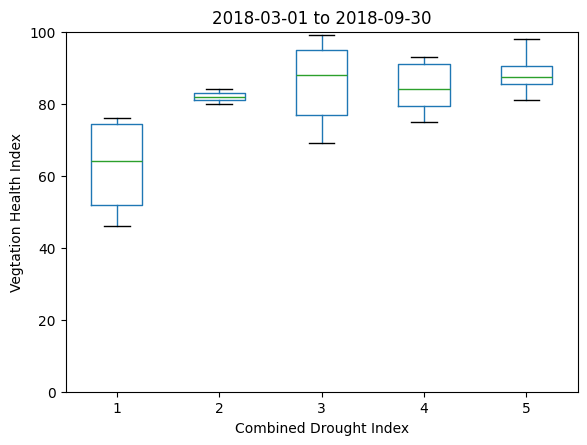

In [96]:
plt.figure(figsize=(10, 6))
ax = df_filtered.boxplot(column='VHI', by='CDI')
plt.xlabel('Combined Drought Index')
plt.ylabel('Vegtation Health Index')
plt.grid(False)
plt.title(str(start_date) + ' to ' + str(end_date))
ax.get_figure().suptitle('', y = 1.0)
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 100)
plt.show()

Not what we expected. A high CDI and a low VHI both mean dry or stressfull conditions. Does not change much when adjusting the thresholds.

We suspect a time lag, with the VHI reacting later. 

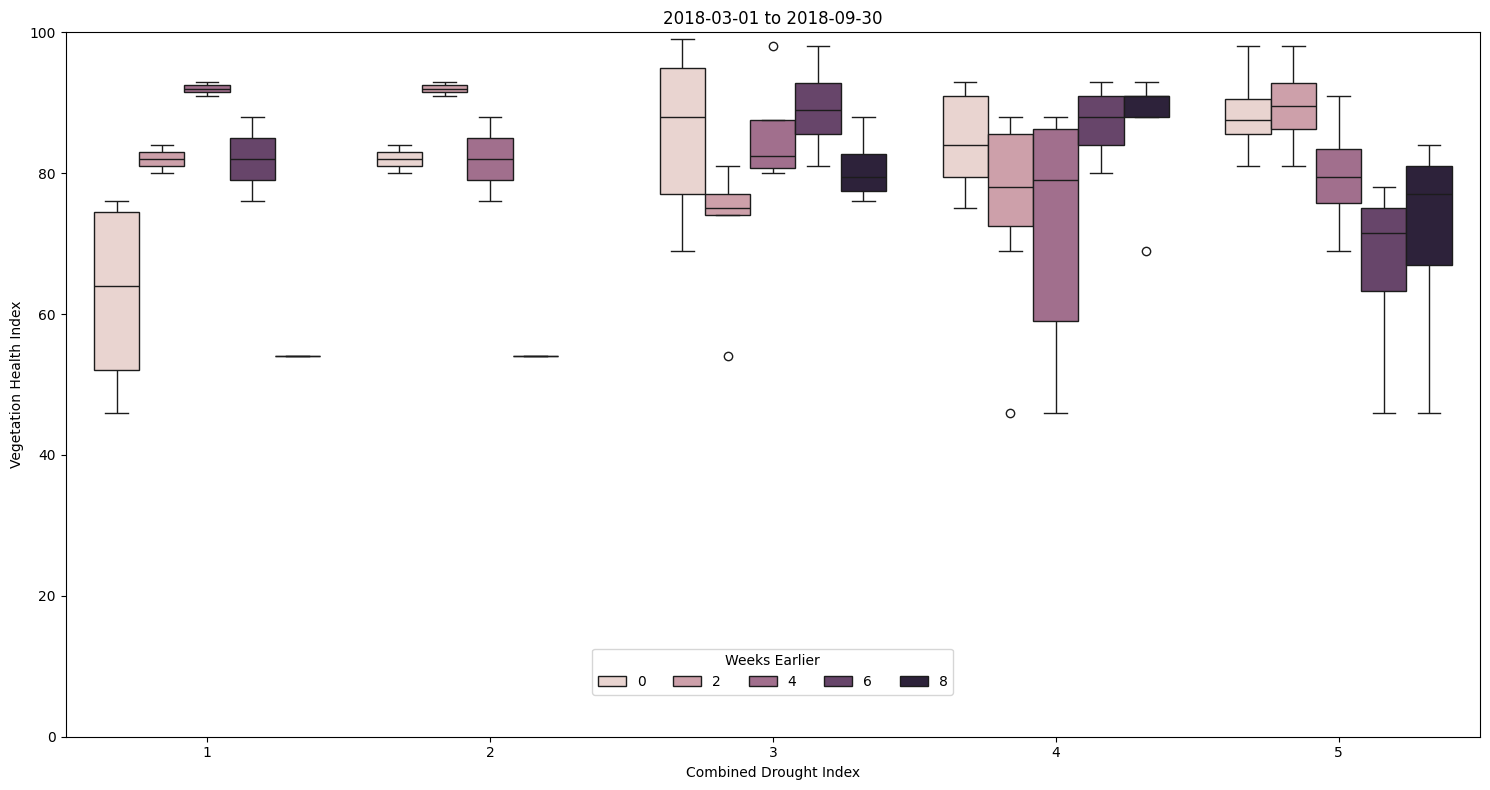

In [112]:
# Create columns for the time-shifted VHI (positive shift, takes a VHI earlier than the CDI)
time_shifts = [0, 2, 4, 6, 8]  # Example time shifts in weeks
for shift in time_shifts:
    df_filtered.loc[:, f'VHI_shifted_{shift}'] = df_filtered.groupby('Region_ID')['VHI'].shift(shift)

# Reshape data to long format
df_melted = df_filtered.melt(id_vars=['CDI', 'Region_ID'], 
                             value_vars=[f'VHI_shifted_{shift}' for shift in time_shifts],
                             var_name='Shift', value_name='VHI_value')
df_melted['Shift'] = df_melted['Shift'].str.extract('(\d+)').astype(int)

cdi_categories = [1, 2, 3, 4, 5]
df_melted['CDI'] = pd.Categorical(df_melted['CDI'].round(), categories=cdi_categories, ordered=True)

plt.figure(figsize=(15, 8))
ax = sns.boxplot(x='CDI', y='VHI_value', hue='Shift', data=df_melted, order=cdi_categories)
plt.xlabel('Combined Drought Index')
plt.ylabel('Vegetation Health Index')
plt.grid(False)
plt.title(f"{start_date} to {end_date}")
plt.legend(title='Weeks Earlier', loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=len(time_shifts))
ax.set_xlim(-0.5, 4.5)
ax.set_xticks(range(5))
ax.set_xticklabels(cdi_categories)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

To do:
- *filter for availability*
- *only summer half year*
- *Comparison between different warn regions, does it work better in certain areas?*